In [1]:
import gym
import numpy as np
from collections import defaultdict
import time
import matplotlib.pyplot as plt

In [2]:
if not hasattr(np, 'bool8'):
    np.bool8 = np.bool_

In [3]:
render_during_training = False   
render_during_simulation = True  
use_slippery = False             # set True for stochastic environment

In [4]:
render_mode_train = "human" if render_during_training else None
render_mode_sim = "human" if render_during_simulation else None

In [5]:
env_train = gym.make("FrozenLake-v1", is_slippery=use_slippery, render_mode=render_mode_train)

In [6]:
num_episodes = 10000
gamma = 0.95
epsilon = 0.3

Returns = defaultdict(float)
Num = defaultdict(int)
Q = defaultdict(float)
episode_rewards = []

In [7]:
def epsilon_greedy_policy(state):
    n_actions = env_train.action_space.n
    action_values = [Q[(state, a)] for a in range(n_actions)]
    best_action = np.argmax(action_values)
    policy = np.ones(n_actions) * (epsilon / n_actions)
    policy[best_action] += 1.0 - epsilon
    return policy

In [8]:
for episode in range(num_episodes):
    state = env_train.reset()[0]
    episode_data = []
    total_reward = 0

    while True:
        if render_during_training:
            env_train.render()

        policy = epsilon_greedy_policy(state)
        action = np.random.choice(np.arange(env_train.action_space.n), p=policy)
        next_state, reward, done, truncated, _ = env_train.step(action)
        episode_data.append((state, action, reward))
        total_reward += reward
        state = next_state
        if done:
            break

    # monte carlo update
    G = 0
    for t in reversed(range(len(episode_data))):
        s_t, a_t, r_t = episode_data[t]
        G = gamma * G + r_t
        if not any((x[0] == s_t and x[1] == a_t) for x in episode_data[:t]):
            Returns[(s_t, a_t)] += G
            Num[(s_t, a_t)] += 1
            Q[(s_t, a_t)] = Returns[(s_t, a_t)] / Num[(s_t, a_t)]

    episode_rewards.append(total_reward)

In [9]:
policy = {}
for state in range(env_train.observation_space.n):
    actions = [Q[(state, a)] for a in range(env_train.action_space.n)]
    policy[state] = np.argmax(actions)

In [10]:
def plot_policy(policy, env):
    arrows = ['←', '↓', '→', '↑']
    desc = env.unwrapped.desc.astype(str)
    size = env.unwrapped.nrow

    print("\nLearned Policy with Map:")
    for i in range(size):
        row = ''
        for j in range(size):
            state = i * size + j
            tile = desc[i][j]

            if tile == 'H' or tile == 'G':
                row += f'{tile} '
            elif tile == 'S':
                row += f'[{arrows[policy[state]]}]'
            else:
                row += f'{arrows[policy[state]]} '
        print(row)

In [11]:
plot_policy(policy, env_train)


Learned Policy with Map:
[↓]→ ↓ ← 
↓ H ↓ H 
→ ↓ ↓ H 
H → → G 


In [12]:
def simulate_run(policy, delay=0.7):
    env_sim = gym.make("FrozenLake-v1", is_slippery=use_slippery, render_mode=render_mode_sim)    
    state = env_sim.reset()[0]
    done = False
    total_reward = 0
    print("\nSimulation Run:")
    time.sleep(2)
    while not done:
        time.sleep(delay)
        action = policy[state]
        state, reward, done, truncated, _ = env_sim.step(action)
        total_reward += reward
    
    print("Total Reward:", total_reward)
    time.sleep(3)
    env_sim.close()

In [13]:
simulate_run(policy)


Simulation Run:
Total Reward: 1.0


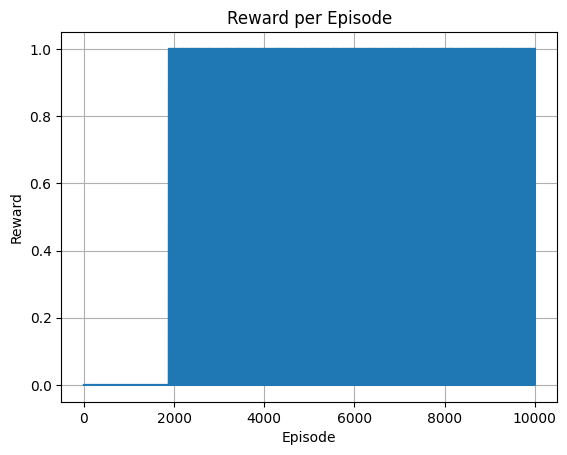

In [14]:
plt.plot(episode_rewards)
plt.title("Reward per Episode")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.grid(True)
plt.show()